In [27]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import os
import patchworklib as pw
import sys
import scipy
import sklearn
import sklearn.metrics
from typing import Callable, Tuple
import collections
from matplotlib import cm
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

sys.path.append('../')
import sim
import parse
import run
import plot
import pad

# Patient properties + model predictions
PATH_TO_INPUT_FOLDER = '../input/pad/'
PATH_TO_DL_MODEL = os.path.join(PATH_TO_INPUT_FOLDER, 'dl.csv')
PATH_TO_RF_MODEL = os.path.join(PATH_TO_INPUT_FOLDER, 'rf.csv')
PATH_TO_LR_MODEL = os.path.join(PATH_TO_INPUT_FOLDER, 'lr.csv')
PATH_TO_MERGED_MODEL = os.path.join(PATH_TO_INPUT_FOLDER, 'merged.csv')
PATH_TO_PATIENT_PROPERTIES = os.path.join(PATH_TO_INPUT_FOLDER, 'properties.csv')

# Workflows
PATH_TO_NURSE_YAML = '../workflows/pad_nurse.yaml'
PATH_TO_DOCTOR_YAML = '../workflows/pad_doctor.yaml'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Patients

In [17]:
df_merged = pad.generate_csv(PATH_TO_DL_MODEL, PATH_TO_RF_MODEL, PATH_TO_LR_MODEL, PATH_TO_PATIENT_PROPERTIES)

---- Read ----
Size: df_dl = (5082, 4) df_rf = (34344, 3) df_lr = (12474, 3)
---- De-duplicate ----
Removed 563 repeated rows in df_dl
Removed 14388 repeated rows in df_rf
Removed 3300 repeated rows in df_lr
Size: df_dl = (4519, 3) df_rf = (19956, 3) df_lr = (9174, 3)
---- Merge ----
# of overlapping patients btwn df_dl and df_rf: 4519
# of overlapping patients btwn df_dl and df_lr: 4478
# of overlapping patients btwn df_lr and df_rf: 9174
Removed 26 rows in df_merged with conflicting 'y' labels
Size: df_merged = (4452, 5)
---- ABI Test ----
ABI sensitivity @ 0.9: 0.9513201320132013
ABI specificity @ 0.9: 0.962037037037037
---- Random Nonce for Resource Priority ----
---- Stats ----
Prevalence of PAD: 0.2722371967654987
P(ABI < 0.4| PAD): 0.04372937293729373
P(ABI < 0.45| PAD): 0.09075907590759076
P(ABI < 0.5| PAD): 0.15759075907590758
P(ABI < 0.55| PAD): 0.2590759075907591
P(ABI < 0.6| PAD): 0.3778877887788779
P(ABI < 0.65| PAD): 0.5099009900990099
P(ABI < 0.7| PAD): 0.648514851485148

# Model Settings

In [18]:
THRESHOLDS = np.linspace(0, 1, 101)
MODELS = ['dl', 'rf', 'lr',]

# Nurse-Driven Workflow

In [19]:
def setup_nurse_optimistic(simulation: sim.Simulation):
    # Reset simulation to "optimistic" case
    simulation.variables['model_threshold']['value'] = 0.5
    # Nurse capacity
    # Wait 1 days for nurse to contact patient
    simulation.variables['wait_for_nurse_time_out']['value'] = 1
    # Total capacity of nurses = 1e5 patients/day
    simulation.variables['nurse_capacity']['init_amount'] = 1e5
    simulation.variables['nurse_capacity']['max_amount'] = 1e5
    simulation.variables['nurse_capacity']['refill_amount'] = 1e5
    simulation.variables['nurse_capacity']['refill_duration'] = 1
    # Specialist
    # Wait 1 days to find time with specialist
    simulation.variables['schedule_specialist_appt_time_out']['value'] = 1
    # Specialist can only see patients on these days of the week
    simulation.variables['specialist_days_in_office']['value'] = [ 0, 1, 2, 3, 4, 5, 6, ]
    # Total capacity of specialist = 1e5 patients/day
    simulation.variables['specialist_capacity']['init_amount'] = 1e5
    simulation.variables['specialist_capacity']['max_amount'] = 1e5
    simulation.variables['specialist_capacity']['refill_amount'] = 1e5
    simulation.variables['specialist_capacity']['refill_duration'] = 1
    

### Workflow

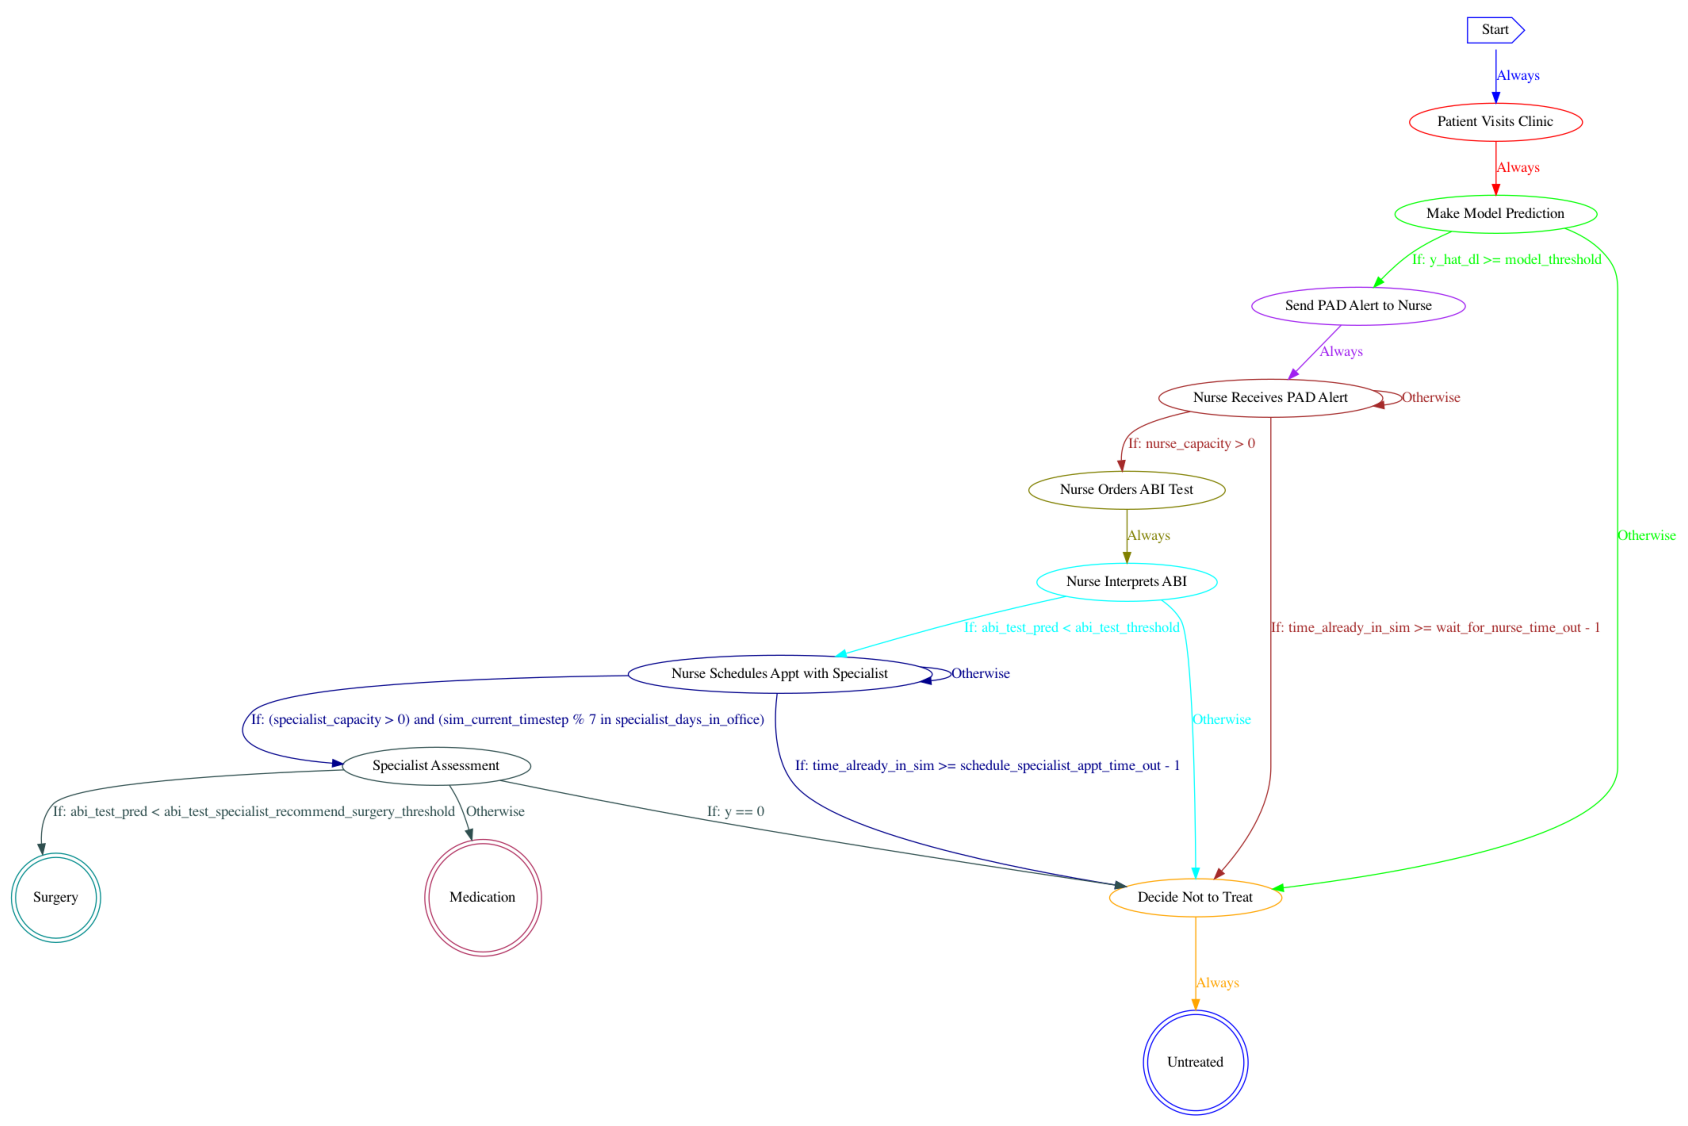

In [20]:
simulation = pad.load_simulation(PATH_TO_NURSE_YAML, PATH_TO_PATIENT_PROPERTIES)
simulation.draw_workflow_diagram(figsize=(30,30))

### Patients

Note: this can be reused for doctor workflow b/c they have the same set of patient properties

In [21]:
all_patients = pad.generate_patient_list(simulation, mean_admits_per_day=35, num_days=500)
all_patients[0].properties

{'abi_test_pred': 0.693035673200502,
 'y': 1.0,
 'y_hat_dl': 0.94534182548523,
 'y_hat_rf': 1.0,
 'y_hat_lr': 0.2922487323034018,
 'random_resource_priority': 3770.0}

### Nurse Capacity (ranked selection, capped specialist)

In [ ]:
values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 1e5 ]
labels = [f"{x}" for x in values ]
settings = [{
                'nurse_capacity' : {
                    'init_amount' : x,
                    'max_amount' : x,
                    'refill_amount' : x,
                    'type' : 'resource',
                    'refill_duration' : 1,
                },
                'specialist_capacity' : {
                    'type' : 'resource',
                    'init_amount' : 2,
                    'max_amount' : 2,
                    'refill_amount' : 2,
                    'refill_duration' : 1,
                },
            } for x in values ]
model_2_result_nurse_cap, baseline_2_result_nurse_cap = pad.run_test(copy.deepcopy(all_patients), 
                                                             labels, 
                                                             settings, 
                                                             MODELS,
                                                             THRESHOLDS,
                                                             PATH_TO_NURSE_YAML,
                                                             PATH_TO_PATIENT_PROPERTIES,
                                                             is_patient_sort_by_y_hat=True, 
                                                             func_setup_optimistic=setup_nurse_optimistic)

         label          y     y_sem color
0            0   0.000000  0.002282    dl
1            1  43.946830  0.002221    dl
2            2  93.312883  0.002143    dl
3            3  99.038855  0.002134    dl
4            4  99.284254  0.002133    dl
10          10  99.345603  0.002133    dl
9            9  99.345603  0.002133    dl
8            8  99.345603  0.002133    dl
6            6  99.345603  0.002133    dl
5            5  99.345603  0.002133    dl
60  optimistic  99.345603  0.002133    dl
7            7  99.345603  0.002133    dl
         label           y     y_sem color
12           0    0.000000  0.002282    rf
13           1   47.709611  0.002213    rf
14           2   91.697342  0.002146    rf
15           3   97.586912  0.002137    rf
16           4   99.182004  0.002134    rf
17           5   99.366053  0.002134    rf
18           6   99.754601  0.002133    rf
19           7   99.815951  0.002133    rf
20           8   99.938650  0.002133    rf
21           9  100.0000

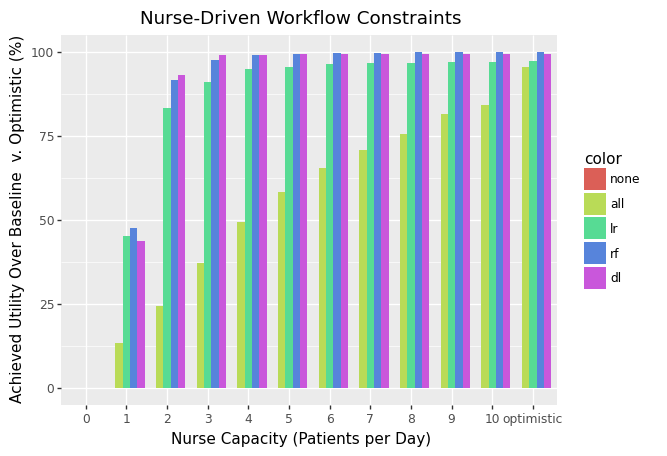

<ggplot: (346144476)>

In [104]:
# Use 1e5 as the 'optimistic' case
df_ = pad.plot_helper(model_2_result_nurse_cap, {
    'all': baseline_2_result_nurse_cap['all'],
    'none': baseline_2_result_nurse_cap['none']
}).rename(columns={'model': 'color'})
df_ = df_[df_['label'] != 'optimistic']
df_optimistic_ = df_[df_['label'] == '100000.0'].copy()
df_optimistic_['label'] = 'optimistic'
df_ = df_.append(df_optimistic_, ignore_index=True)
df_ = df_[df_['label'] != '100000.0']
plot.plot_dodged_bar_mean_utilities('Nurse-Driven Workflow Constraints',
                                    df_,
                                    label_sort_order=[
                                        '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'optimistic', ],
                                    color_sort_order=[
                                        'none', 'all', 'lr', 'rf', 'dl', ],  # no 'perfect'
                                    is_percent_of_optimistic=1,
                                    x_label='Nurse Capacity (Patients per Day)')


# Doctor-Driven Workflow

In [48]:
def setup_doctor_optimistic(simulation: sim.Simulation):
    # Reset simulation to "optimistic" case
    simulation.variables['model_threshold']['value'] = 0.5
    # Doctor probs
    simulation.variables['prob_pad_alert_is_read']['value'] = 1
    simulation.variables['prob_doctor_orders_abi']['value'] = 1
    simulation.variables['prob_specialist_follow_up_completed']['value'] = 1
    simulation.variables['abi_test_treat_immediately_threshold']['value'] = 100
    # Specialist
    # Wait 1 days to find time with specialist
    simulation.variables['schedule_specialist_appt_time_out']['value'] = 1
    # Specialist can only see patients on these days of the week
    simulation.variables['specialist_days_in_office']['value'] = [ 0, 1, 2, 3, 4, 5, 6,]
    # Total capacity of specialist = 1e5 patients/day
    simulation.variables['specialist_capacity']['init_amount'] = 1e5
    simulation.variables['specialist_capacity']['max_amount'] = 1e5
    simulation.variables['specialist_capacity']['refill_amount'] = 1e5
    simulation.variables['specialist_capacity']['refill_duration'] = 1

### Workflow

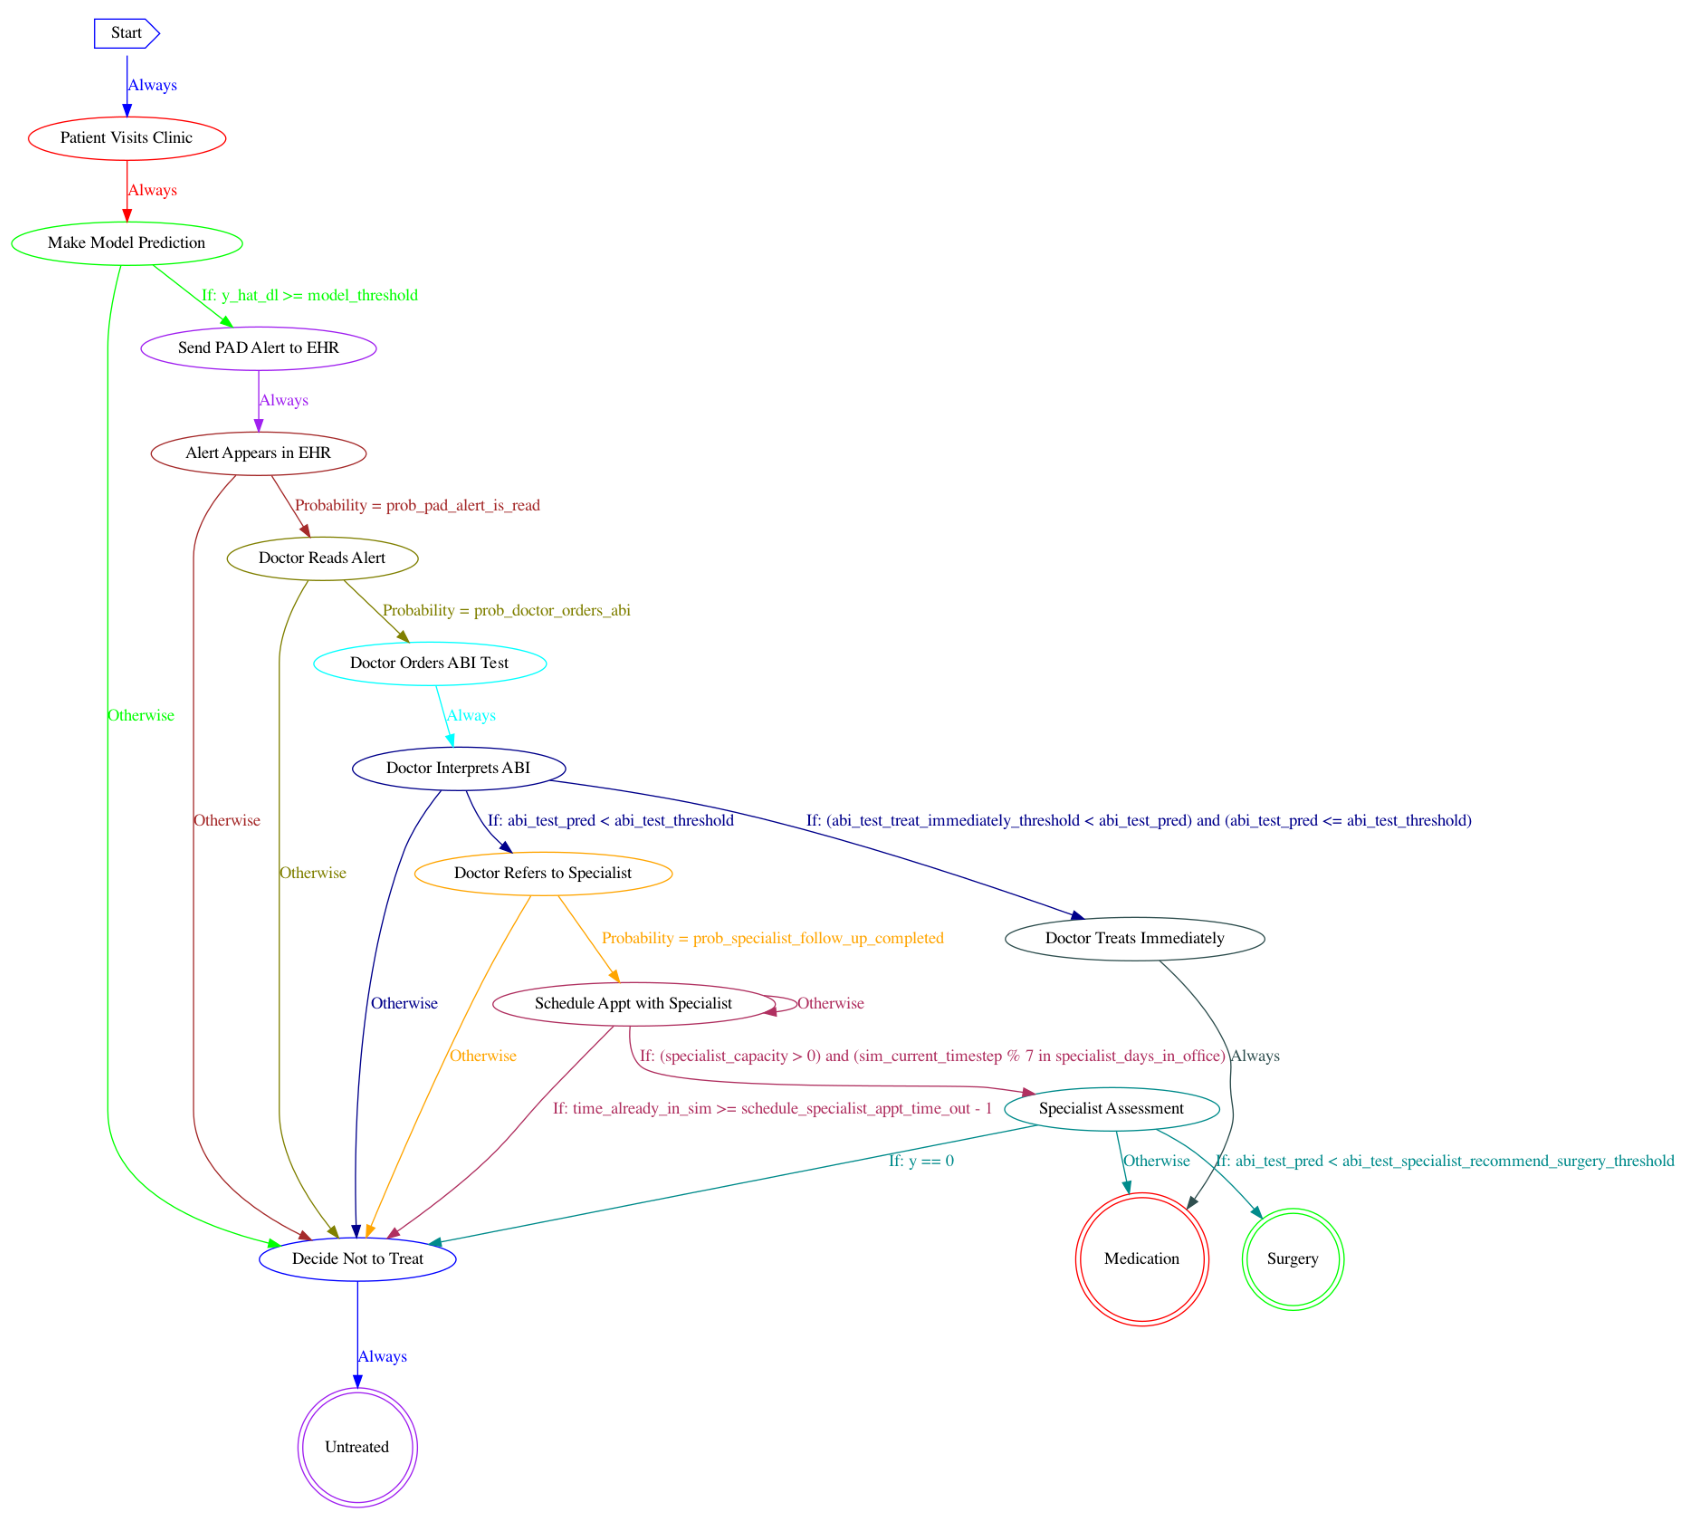

In [49]:
simulation = pad.load_simulation(PATH_TO_DOCTOR_YAML, PATH_TO_PATIENT_PROPERTIES)
simulation.draw_workflow_diagram(figsize=(30,30))

### Doctor Read Alert Prob (thresholded selection, specialist capped)

In [ ]:
values = [0, .1, .2, .3, .4, .6, .7, .8, .9, 1 ]
labels = [f"{x}" for x in values ]
settings = [{
                'prob_pad_alert_is_read' : {
                    'type' : 'scalar',
                    'value' : x,
                },
                'specialist_capacity' : {
                    'type' : 'resource',
                    'init_amount' : 2,
                    'max_amount' : 2,
                    'refill_amount' : 2,
                    'refill_duration' : 1,
                },
            } for x in values ]
model_2_result_alert_random_cap, baseline_2_result_alert_random_cap = pad.run_test(copy.deepcopy(all_patients),
                                                                                   labels,
                                                                                   settings,
                                                                                   MODELS,
                                                                                   THRESHOLDS,
                                                                                   PATH_TO_DOCTOR_YAML,
                                                                                   PATH_TO_PATIENT_PROPERTIES,
                                                                                   is_patient_sort_by_y_hat=False,
                                                                                   func_setup_optimistic=setup_doctor_optimistic)


         label           y     y_sem color
0            0    0.000000  0.002282    dl
1          0.1   38.514443  0.002222    dl
2          0.2   55.728041  0.002197    dl
3          0.3   75.673020  0.002163    dl
4          0.4   86.460994  0.002146    dl
5          0.6   96.030654  0.002131    dl
7          0.8   98.270780  0.002128    dl
6          0.7   99.921399  0.002122    dl
50  optimistic  100.000000  0.002124    dl
9            1  100.000000  0.002124    dl
8          0.9  102.004323  0.002118    dl
         label          y     y_sem color
10           0   0.000000  0.002282    rf
11         0.1  16.977795  0.002255    rf
12         0.2  27.942621  0.002239    rf
13         0.3  38.141089  0.002224    rf
14         0.4  49.990175  0.002206    rf
15         0.6  67.400275  0.002177    rf
16         0.7  72.018078  0.002172    rf
17         0.8  75.555119  0.002165    rf
18         0.9  80.585577  0.002159    rf
19           1  84.810375  0.002151    rf
51  optimistic  84.810

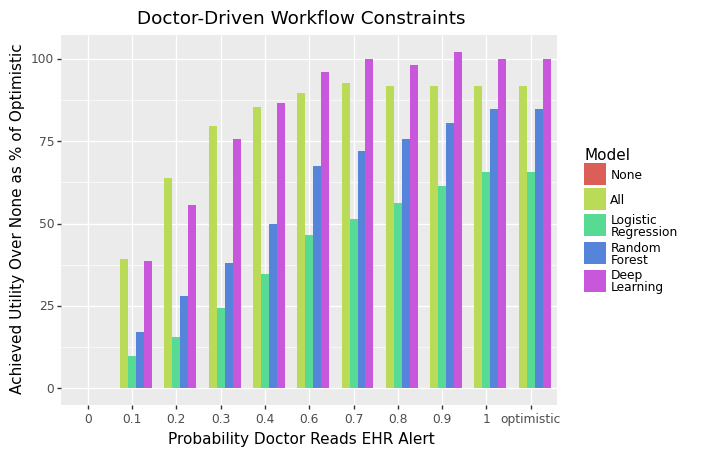

<ggplot: (356433490)>

In [111]:
df_ = pad.plot_helper(model_2_result_alert_random_cap, {'all': baseline_2_result_alert_random_cap['all'],
                                                        'none': baseline_2_result_alert_random_cap['none']
                                                        }, threshold=0.5).rename(columns={'model': 'color'})
df_ = df_[df_['label'] != 'optimistic']
df_optimistic_ = df_[df_['label'] == '1'].copy()
df_optimistic_['label'] = 'optimistic'
df_ = df_.append(df_optimistic_, ignore_index=True)
plot.plot_dodged_bar_mean_utilities('Doctor-Driven Workflow Constraints',
                                    df_,
                                    label_sort_order=[
                                        '0', '0.1', '0.2',
                                        '0.3', '0.4',
                                        '0.6', '0.7', '0.8',
                                        '0.9', '1', 'optimistic', ],
                                    color_sort_order=[
                                        'none', 'all', 'lr', 'rf', 'dl', ],
                                    is_percent_of_optimistic=1,
                                    x_label='Probability Doctor Reads EHR Alert')

# DL Model - Doctor-Driven v. Nurse-Driven Utilities

### Assuming Specialist Capacity = 2 patients/day

In [ ]:
# Doctor
values = np.linspace(0, 1, 11)
labels = [f"{x}" for x in values ]
settings = [{
                'prob_pad_alert_is_read' : {
                    'type' : 'scalar',
                    'value' : x,
                },
                'specialist_capacity' : {
                    'type' : 'resource',
                    'init_amount' : 2,
                    'max_amount' : 2,
                    'refill_amount' : 2,
                    'refill_duration' : 1,
                },
            } for x in values ]
m2r_doctor, b2r_doctor = pad.run_test(copy.deepcopy(all_patients),
                                        labels,
                                        settings,
                                        ['dl'],
                                        THRESHOLDS,
                                        PATH_TO_DOCTOR_YAML,
                                        PATH_TO_PATIENT_PROPERTIES,
                                        is_patient_sort_by_y_hat=True,
                                        func_setup_optimistic=setup_doctor_optimistic)

In [ ]:
# Nurse
values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ]
labels = [f"{x}" for x in values ]
settings = [{
                'nurse_capacity' : {
                    'type' : 'resource',
                    'init_amount' : x,
                    'max_amount' : x,
                    'refill_amount' : x,
                    'refill_duration' : 1,
                },
                'specialist_capacity' : {
                    'type' : 'resource',
                    'init_amount' : 2,
                    'max_amount' : 2,
                    'refill_amount' : 2,
                    'refill_duration' : 1,
                },
            } for x in values ]
m2r_nurse, b2r_nurse = pad.run_test(copy.deepcopy(all_patients),
                                        labels,
                                        settings,
                                        ['dl'],
                                        [0], # Only need to test one threshold because using ranked threshold
                                        PATH_TO_NURSE_YAML,
                                        PATH_TO_PATIENT_PROPERTIES,
                                        is_patient_sort_by_y_hat=True,
                                        func_setup_optimistic=setup_nurse_optimistic)

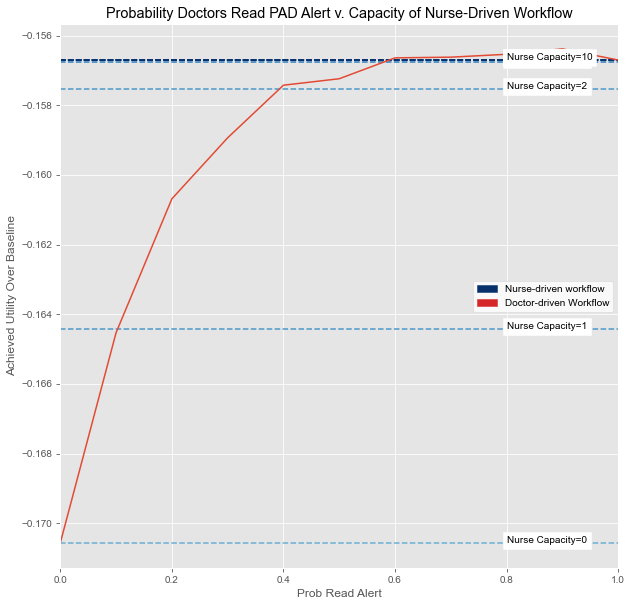

In [95]:
df_nurse = pad.plot_helper(m2r_nurse, b2r_nurse)
df_doctor = pad.plot_helper(m2r_doctor, b2r_doctor)

fig, ax = plt.subplots(figsize=(10,10))
n = df_nurse[(df_nurse['model'] == 'dl') & (df_nurse['label'] != 'optimistic')]
d = df_doctor[(df_doctor['model'] == 'dl') & (df_doctor['label'] != 'optimistic')]
d['label'] = d['label'].astype(float)
nurse_colors = cm.get_cmap('Blues', n.shape[0])(np.linspace(0.5, 1, n.shape[0]))
for idx, row in n.iterrows():
    plt.plot([d['label'].min(), d['label'].max()], 
             [row['y'], row['y']], 
             '--', 
             color=nurse_colors[idx])
    plt.text(.8, row['y'], f"Nurse Capacity={row['label']}", backgroundcolor='white')
plt.plot(d['label'], d['y'])
plt.ylabel('Achieved Utility Over Baseline')
plt.xlabel('Prob Read Alert')
plt.title("Probability Doctors Read PAD Alert v. Capacity of Nurse-Driven Workflow")
plt.margins(x=0)
blue_patch = mpatches.Patch(color=nurse_colors[-1], label='Nurse-driven workflow')
red_patch = mpatches.Patch(color='tab:red', label='Doctor-driven Workflow')
ax.legend(handles=[blue_patch, red_patch], loc='center right', facecolor='white')

### Assuming Specialist Capacity = Unlimited

In [ ]:
# Doctor
values = np.linspace(0, 1, 11)
labels = [f"{x}" for x in values ]
settings = [{
                'prob_pad_alert_is_read' : {
                    'type' : 'scalar',
                    'value' : x,
                },
            } for x in values ]
m2r_doctor_no_cap, b2r_doctor_no_cap = pad.run_test(copy.deepcopy(all_patients),
                                        labels,
                                        settings,
                                        ['dl'],
                                        THRESHOLDS,
                                        PATH_TO_DOCTOR_YAML,
                                        PATH_TO_PATIENT_PROPERTIES,
                                        is_patient_sort_by_y_hat=True,
                                        func_setup_optimistic=setup_doctor_optimistic)

In [ ]:
# Nurse
values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ]
labels = [f"{x}" for x in values ]
settings = [{
                'nurse_capacity' : {
                    'type' : 'resource',
                    'init_amount' : x,
                    'max_amount' : x,
                    'refill_amount' : x,
                    'refill_duration' : 1,
                },
            } for x in values ]
m2r_nurse_no_cap, b2r_nurse_no_cap = pad.run_test(copy.deepcopy(all_patients),
                                        labels,
                                        settings,
                                        ['dl'],
                                        [0], # Only need to test one threshold because using ranked threshold
                                        PATH_TO_NURSE_YAML,
                                        PATH_TO_PATIENT_PROPERTIES,
                                        is_patient_sort_by_y_hat=True,
                                        func_setup_optimistic=setup_nurse_optimistic)

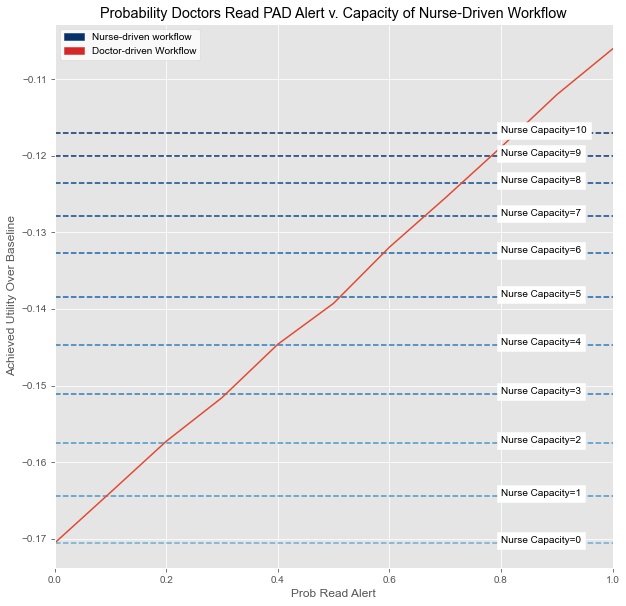

In [100]:
df_nurse = pad.plot_helper(m2r_nurse_no_cap, b2r_nurse_no_cap)
df_doctor = pad.plot_helper(m2r_doctor_no_cap, b2r_doctor_no_cap)

fig, ax = plt.subplots(figsize=(10,10))
n = df_nurse[(df_nurse['model'] == 'dl') & (df_nurse['label'] != 'optimistic')]
d = df_doctor[(df_doctor['model'] == 'dl') & (df_doctor['label'] != 'optimistic')]
d['label'] = d['label'].astype(float)
nurse_colors = cm.get_cmap('Blues', n.shape[0])(np.linspace(0.5, 1, n.shape[0]))
for idx, row in n.iterrows():
    plt.plot([d['label'].min(), d['label'].max()], 
             [row['y'], row['y']], 
             '--', 
             color=nurse_colors[idx])
    plt.text(.8, row['y'], f"Nurse Capacity={row['label']}", backgroundcolor='white')
plt.plot(d['label'], d['y'])
plt.ylabel('Achieved Utility Over Baseline')
plt.xlabel('Prob Read Alert')
plt.title("Probability Doctors Read PAD Alert v. Capacity of Nurse-Driven Workflow")
plt.margins(x=0)
blue_patch = mpatches.Patch(color=nurse_colors[-1], label='Nurse-driven workflow')
red_patch = mpatches.Patch(color='tab:red', label='Doctor-driven Workflow')
ax.legend(handles=[blue_patch, red_patch], facecolor='white')

# Model Performance

In [578]:
UTILITIES = {
    'tp' : -0.35,
    'fp' : -0.2,
    'tn' : 0,
    'fn' : -1,
}

[5.61245542e-05 7.53879547e-04 5.44518232e-04 ... 2.79874021e-05
 4.72801924e-03 7.59263523e-04]


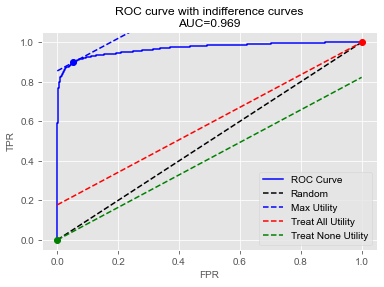

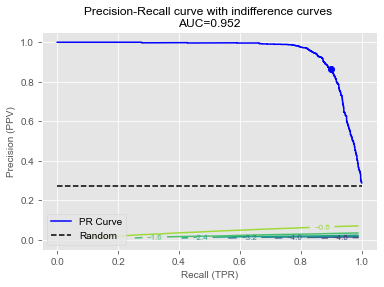

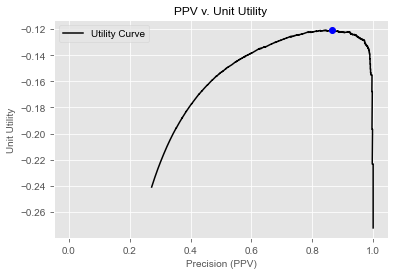

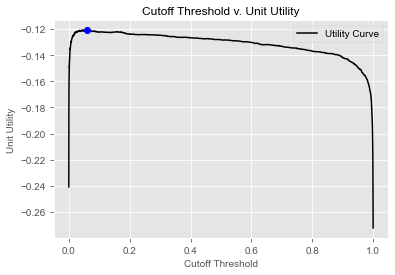

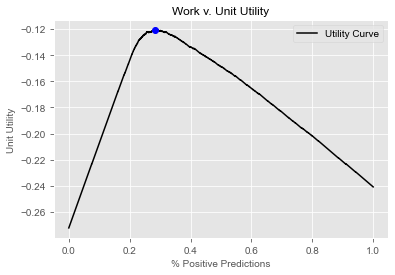

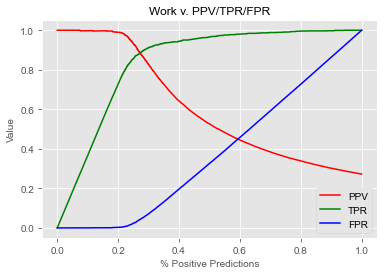

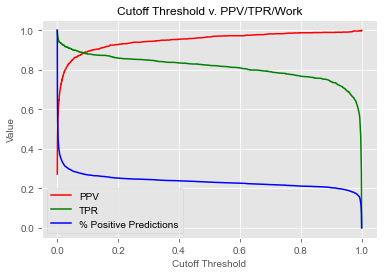

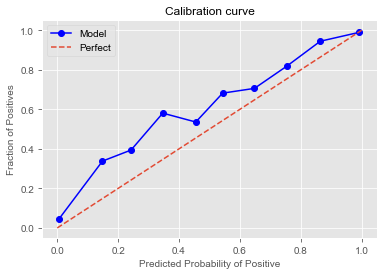

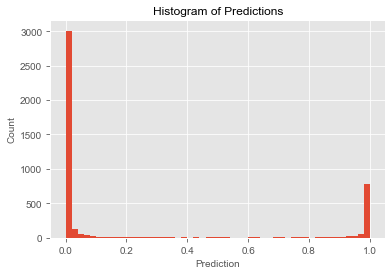

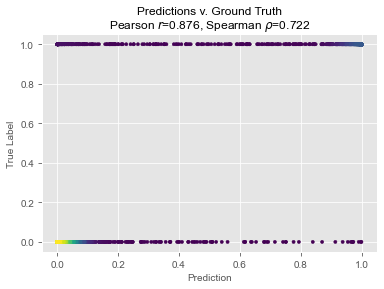

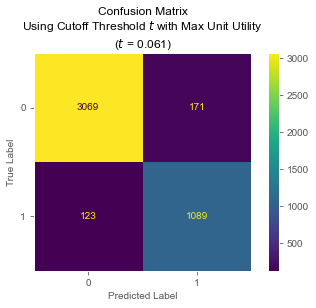

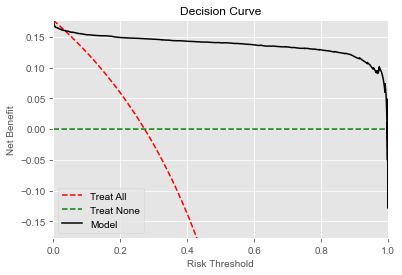

In [650]:
# Deep Learning
plot.make_model_utility_plots(df_merged.rename(columns = { 'y_hat_dl' : 'y_hat' }), 
                              UTILITIES, 
                              is_show = True)

[0.01428571 0.01428571 0.21904762 ... 0.13809524 0.07142857 0.05714286]


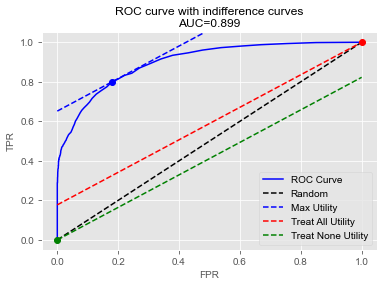

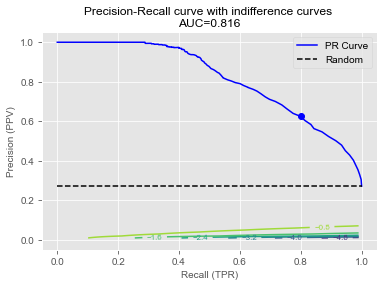

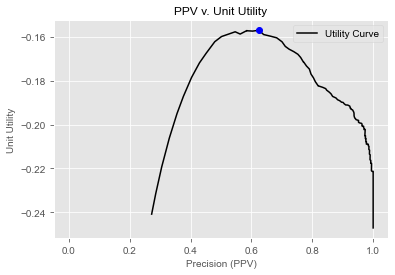

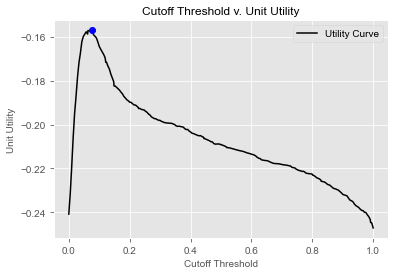

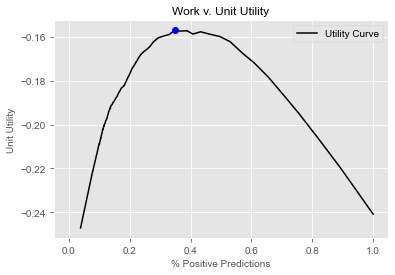

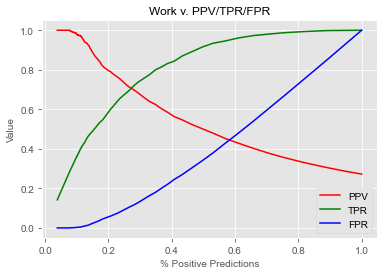

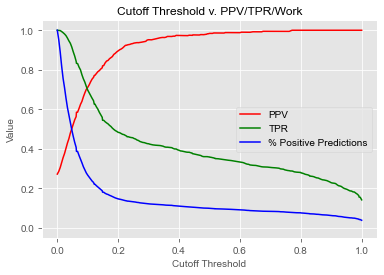

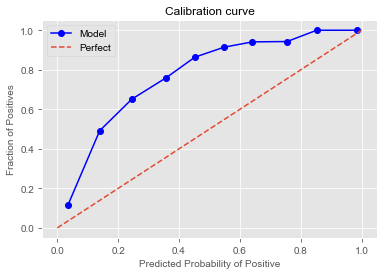

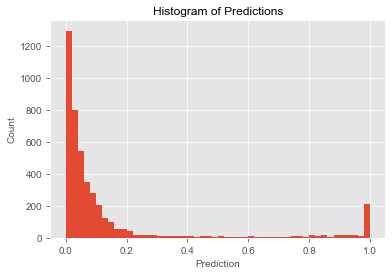

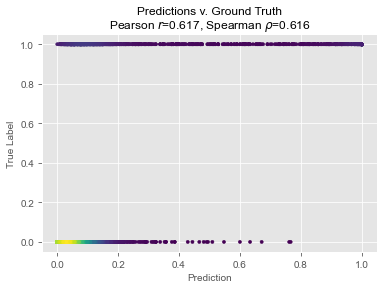

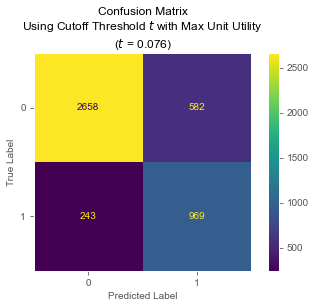

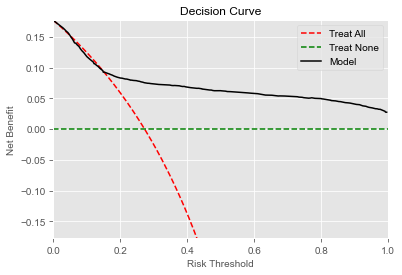

In [651]:
# Random Forest
plot.make_model_utility_plots(df_merged.rename(columns = { 'y_hat_rf' : 'y_hat' }), 
                              UTILITIES, 
                              is_show = True)

[0.01914431 0.03135225 0.1070151  ... 0.02850361 0.08396317 0.1266214 ]


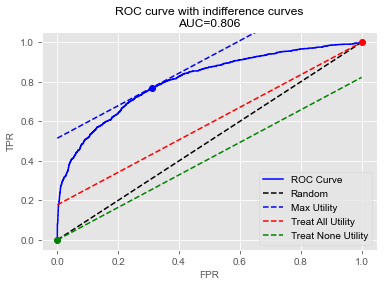

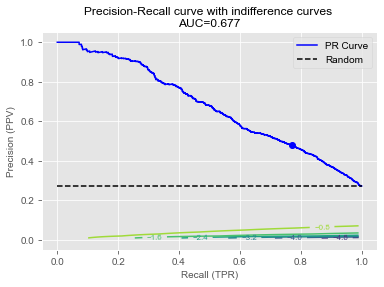

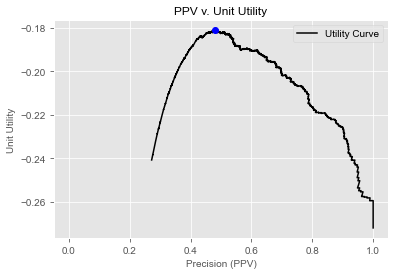

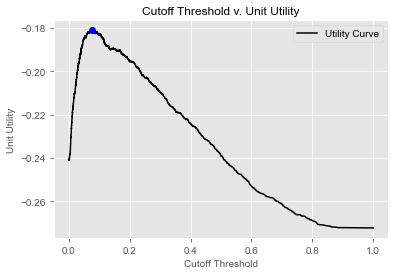

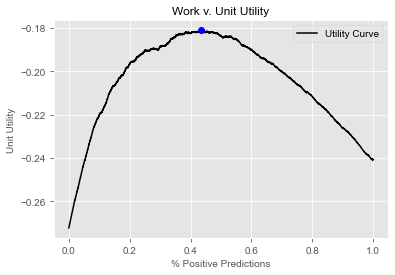

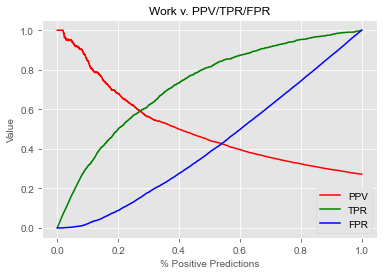

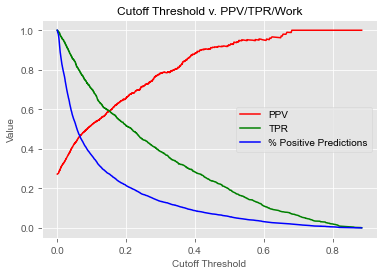

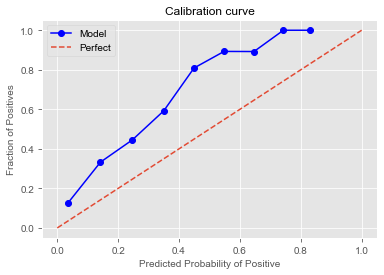

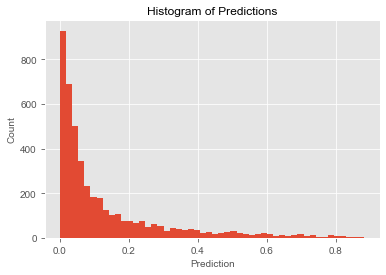

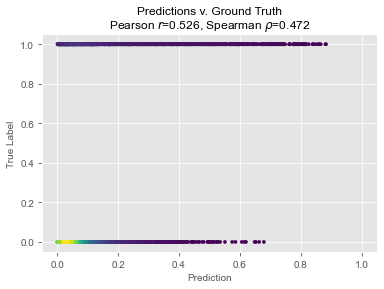

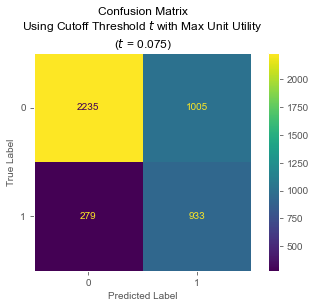

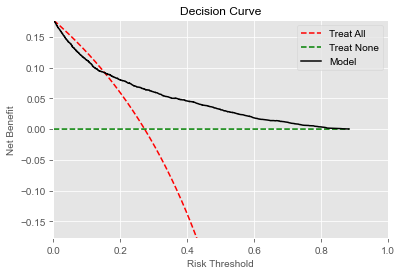

In [652]:
# Logistic Regression
plot.make_model_utility_plots(df_merged.rename(columns = { 'y_hat_lr' : 'y_hat' }), 
                              UTILITIES, 
                              is_show = True)